<a href="https://colab.research.google.com/github/dietadestina/PA_EVCast/blob/main/Modelling_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SPLITTING DATA 80:20**

In [186]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Membaca dataset
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/main/ev_sales.csv')

# Mengelompokkan data berdasarkan tahun
yearly_sales = ev_sales.groupby('Year', as_index=False)['Value'].sum()

# Visualisasi penjualan tahunan
yearly_sales_sc = go.Scatter(x=yearly_sales['Year'], y=yearly_sales['Value'], mode='lines+markers')
layout = go.Layout(title='Yearly Sales', xaxis=dict(title='Year'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[yearly_sales_sc], layout=layout)
iplot(fig)

In [187]:
# Normalisasi nilai penjualan
from sklearn.preprocessing import MinMaxScaler

# Menggunakan MinMaxScaler untuk menormalisasi kolom 'Value'
scaler = MinMaxScaler(feature_range=(0, 1))
yearly_sales['Value'] = scaler.fit_transform(yearly_sales['Value'].values.reshape(-1, 1))

# Mengubah data menjadi format yang sesuai untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Mengubah dataframe menjadi numpy array
data = yearly_sales['Value'].values
data = data.reshape(-1, 1)

# Menetapkan jumlah langkah waktu
time_step = 1
X, y = create_dataset(data, time_step)

# Reshape input ke dalam bentuk [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
X

array([[[0.        ]],

       [[0.02210969]],

       [[0.06964897]],

       [[0.11337253]],

       [[0.14020984]],

       [[0.09035956]],

       [[0.19344039]],

       [[0.51921771]]])

In [188]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

In [190]:
# Melatih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=10)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0805 - val_loss: 0.0104
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0755 - val_loss: 0.0055
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1549 - val_loss: 0.0037
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0877 - val_loss: 0.0055
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2491 - val_loss: 0.0106
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1067 - val_loss: 0.0176
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0708 - val_loss: 0.0227
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0737 - val_loss: 0.0292
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0601 - val_loss: 0.0310
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1223 - val_loss: 0.0390


In [191]:
# Melakukan prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Menghitung RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Train RMSE: 0.316012769761005
Test RMSE: 0.19746949301664699


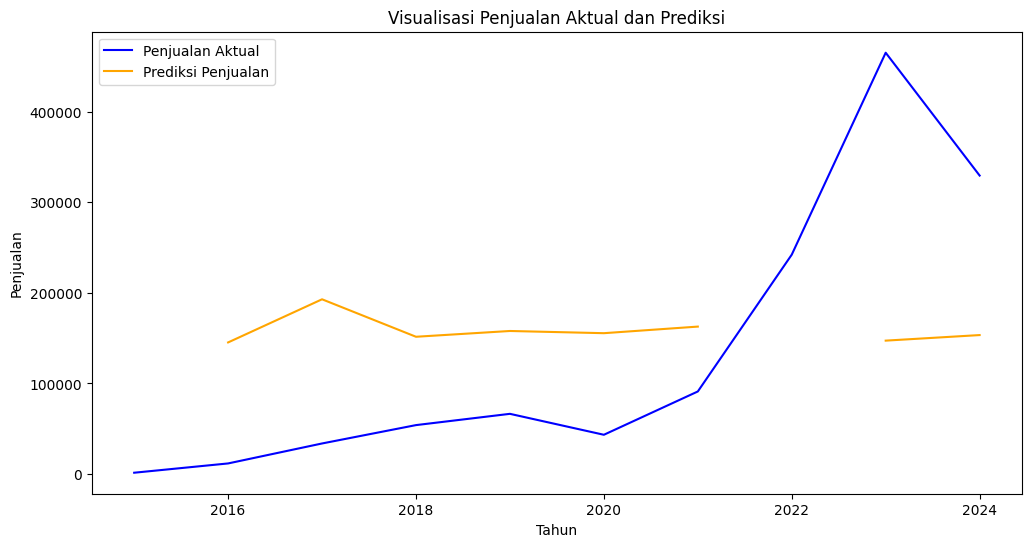

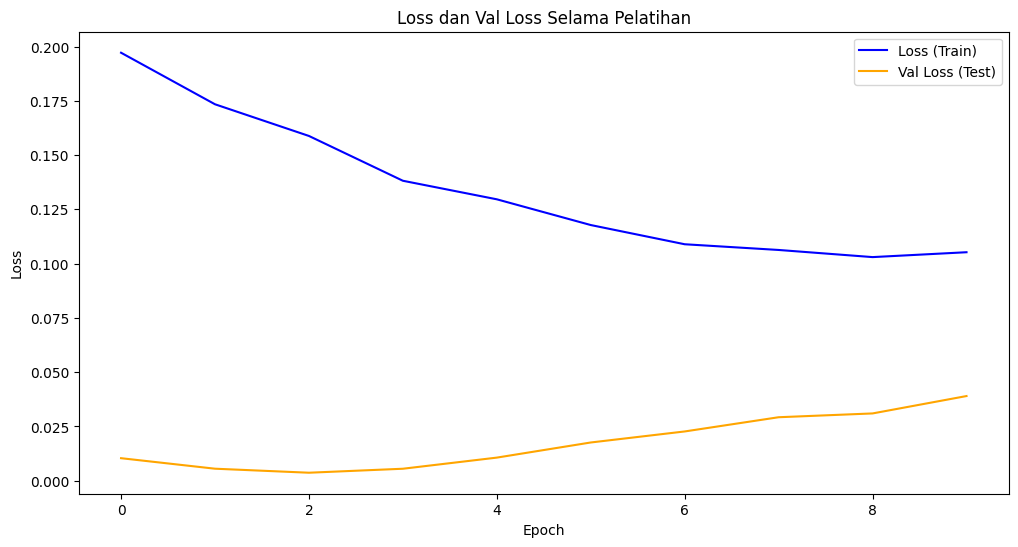

In [192]:
# Invers transformasi untuk mendapatkan nilai penjualan asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Menyusun array untuk visualisasi
predicted_sales = np.empty_like(data)
predicted_sales[:, :] = np.nan  # Inisialisasi dengan NaN

# Menempatkan prediksi train ke posisi yang benar
predicted_sales[time_step:len(train_predict) + time_step, :] = train_predict

# Menempatkan prediksi test ke posisi yang benar
start_index = len(train_predict) + time_step * 2
end_index = start_index + len(test_predict)
predicted_sales[start_index:end_index, :] = test_predict

# Menggabungkan hasil penjualan nyata dan prediksi untuk visualisasi
actual_sales = scaler.inverse_transform(data)  # Mengembalikan data ke skala asli

# Visualisasi penjualan tahunan dengan prediksi
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.title('Visualisasi Penjualan Aktual dan Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Visualisasi loss dan val_loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss (Test)', color='orange')
plt.title('Loss dan Val Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**TANPA SPLITTING DATA**

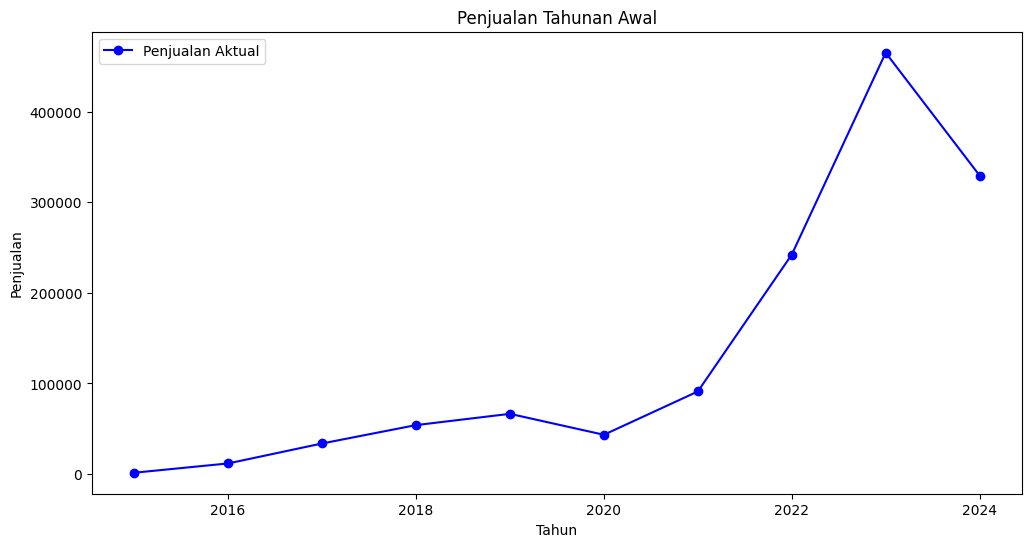

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0755
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1911     
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1203 
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444     
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0606 
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1893 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0513 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0526 
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0678 
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0772 
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0771 
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1066 
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1144 
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0900 
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414 
Epoch 16/100

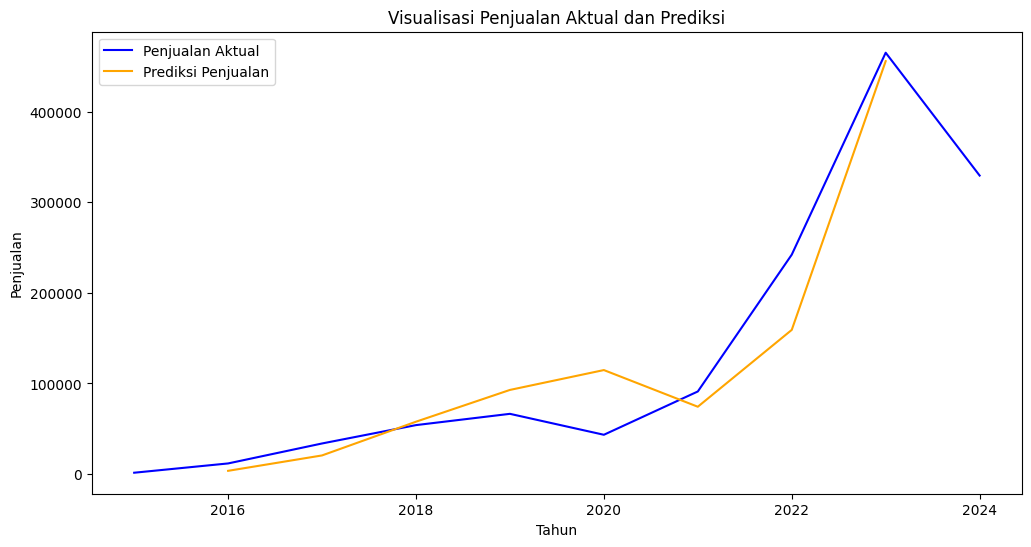

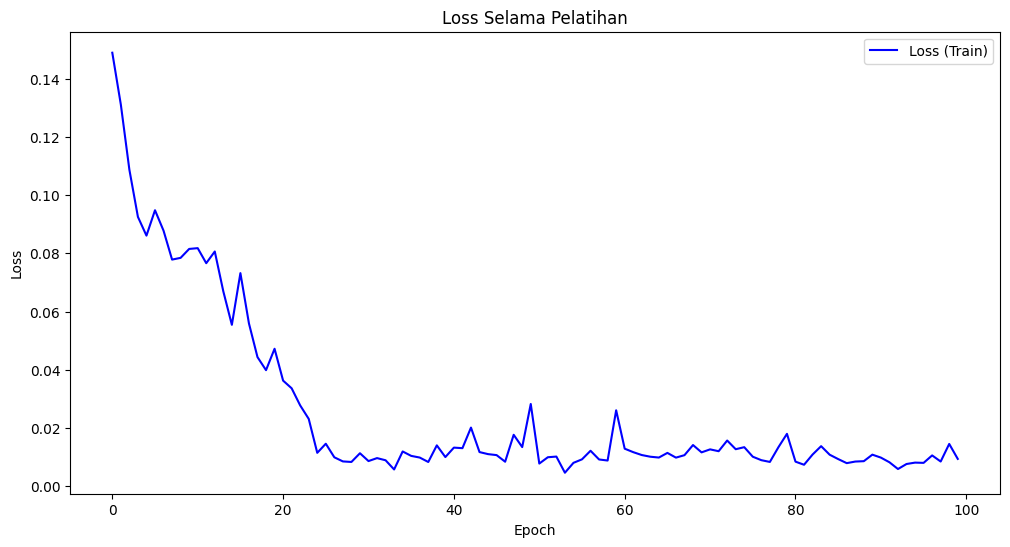

In [193]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Membaca dataset
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/main/ev_sales.csv')

# Mengelompokkan data berdasarkan tahun
yearly_sales = ev_sales.groupby('Year', as_index=False)['Value'].sum()

# Visualisasi penjualan tahunan awal
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Value'], label='Penjualan Aktual', color='blue', marker='o')
plt.title('Penjualan Tahunan Awal')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Normalisasi nilai penjualan
scaler = MinMaxScaler(feature_range=(0, 1))
yearly_sales['Value'] = scaler.fit_transform(yearly_sales['Value'].values.reshape(-1, 1))

# Mengubah data menjadi format yang sesuai untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Mengubah dataframe menjadi numpy array
data = yearly_sales['Value'].values
data = data.reshape(-1, 1)

# Menetapkan jumlah langkah waktu
time_step = 1
X, y = create_dataset(data, time_step)

# Reshape input ke dalam bentuk [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Membangun model LSTM dengan lebih banyak dropout
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))  # Meningkatkan dropout
model.add(Dense(25))
model.add(Dense(1))

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model dengan seluruh data
history = model.fit(X, y, batch_size=1, epochs=100)  # Menggunakan seluruh data

# Melakukan prediksi pada seluruh data
predicted_sales = model.predict(X)

# Invers transformasi untuk mendapatkan nilai penjualan asli
predicted_sales = scaler.inverse_transform(predicted_sales)

# Menggabungkan hasil penjualan nyata dan prediksi untuk visualisasi
actual_sales = scaler.inverse_transform(data)

# Visualisasi penjualan tahunan dengan prediksi
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'][time_step:len(predicted_sales) + time_step], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.title('Visualisasi Penjualan Aktual dan Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Visualisasi loss selama pelatihan
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.title('Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**TAHUN 2020**

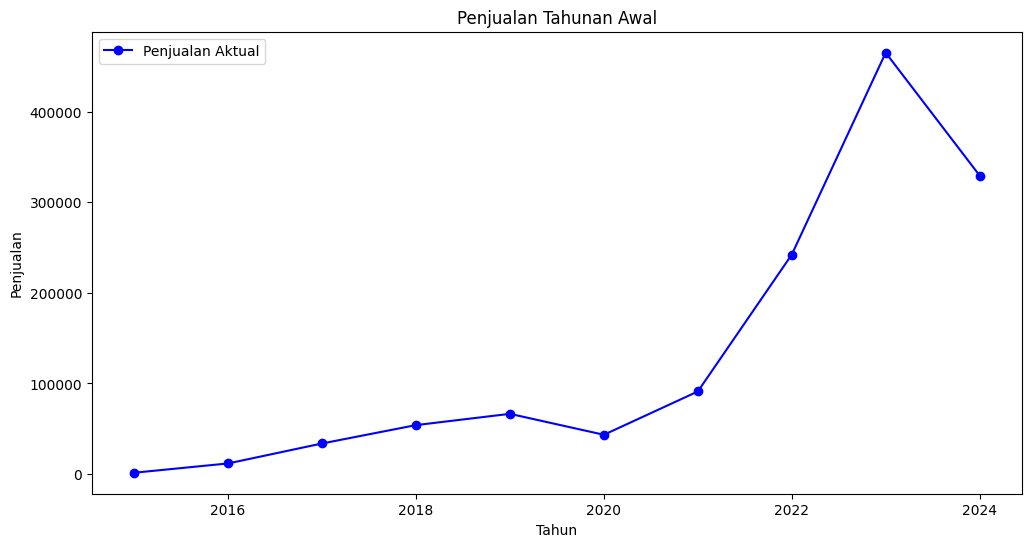

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0123 - val_loss: 0.4891
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 0.4233
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.3837
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 0.3738
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0039 - val_loss: 0.3962
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - val_loss: 0.4114
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.4077
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.4063
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - val_loss: 0.4076
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025 - val_loss: 0.3992
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 0.3767
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss:

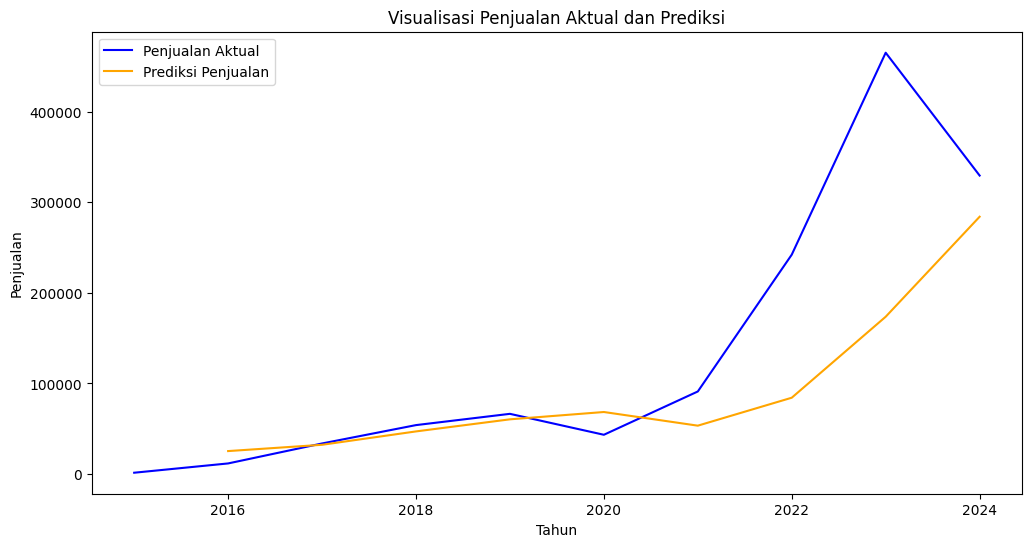

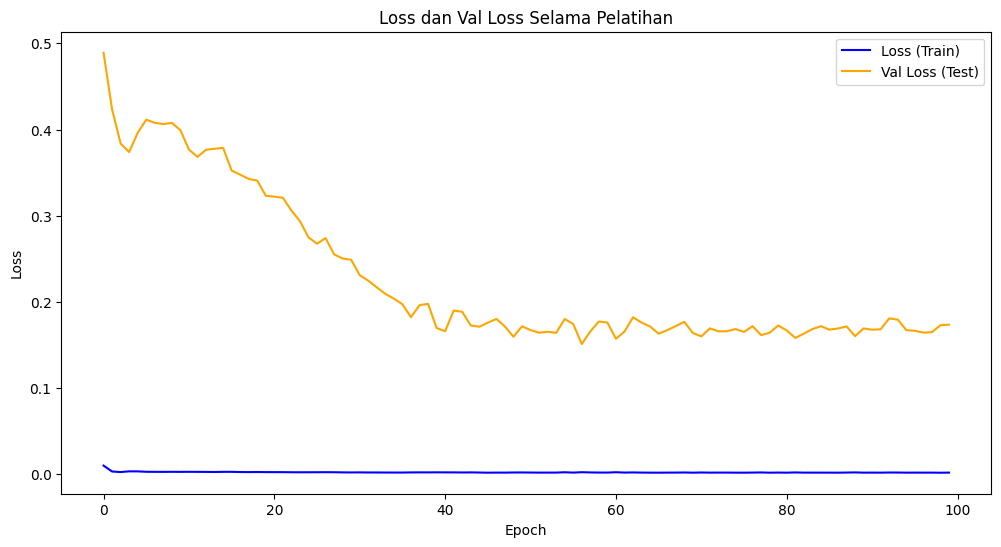

In [197]:
# Membaca dataset
ev_sales = pd.read_csv('https://raw.githubusercontent.com/dietadestina/PA_EVCast/main/ev_sales.csv')

# Mengelompokkan data berdasarkan tahun
yearly_sales = ev_sales.groupby('Year', as_index=False)['Value'].sum()

# Visualisasi penjualan tahunan awal
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], yearly_sales['Value'], label='Penjualan Aktual', color='blue', marker='o')
plt.title('Penjualan Tahunan Awal')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Normalisasi nilai penjualan
scaler = MinMaxScaler(feature_range=(0, 1))
yearly_sales['Value'] = scaler.fit_transform(yearly_sales['Value'].values.reshape(-1, 1))

# Mengubah data menjadi format yang sesuai untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Mengubah dataframe menjadi numpy array
data = yearly_sales['Value'].values
data = data.reshape(-1, 1)

# Menetapkan jumlah langkah waktu
time_step = 1
X, y = create_dataset(data, time_step)

# Reshape input ke dalam bentuk [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Pembagian data berdasarkan tahun
# Mengambil data tahun
years = yearly_sales['Year'].values[:-time_step]  # Mengurangi satu untuk menyesuaikan dengan ukuran y

# Menentukan batas tahun untuk pembagian data
train_year = 2020
train_indices = years <= train_year
test_indices = years > train_year

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Mengompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model dan menyimpan riwayat pelatihan
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=100)

# Melakukan prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Menghitung RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

# Invers transformasi untuk mendapatkan nilai penjualan asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Menyusun array untuk visualisasi
predicted_sales = np.empty_like(data)
predicted_sales[:, :] = np.nan  # Inisialisasi dengan NaN

# Menempatkan prediksi train ke posisi yang benar
predicted_sales[time_step:len(train_predict) + time_step, :] = train_predict

# Menempatkan prediksi test ke posisi yang benar
start_index = len(train_predict) + time_step
predicted_sales[start_index:start_index + len(test_predict), :] = test_predict

# Menggabungkan hasil penjualan nyata dan prediksi untuk visualisasi
actual_sales = scaler.inverse_transform(data)  # Mengembalikan data ke skala asli

# Visualisasi penjualan tahunan dengan prediksi
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales['Year'], actual_sales, label='Penjualan Aktual', color='blue')
plt.plot(yearly_sales['Year'], predicted_sales, label='Prediksi Penjualan', color='orange')
plt.title('Visualisasi Penjualan Aktual dan Prediksi')
plt.xlabel('Tahun')
plt.ylabel('Penjualan')
plt.legend()
plt.show()

# Visualisasi loss dan val_loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss (Test)', color='orange')
plt.title('Loss dan Val Loss Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()